# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
  1
 -1
 -1
 -1
 -1
 -1
  1
 -1
  1
  1
  ⋮
  1
  1
 -1
  1
  1
 -1
  1
  1
  1

### We create a function to visualize the data

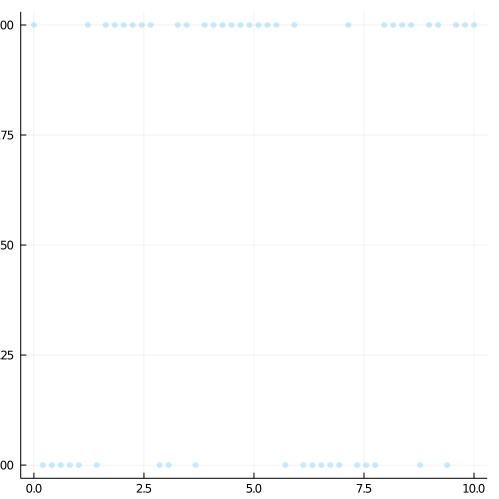

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.039495 seconds (1.87 M allocations: 106.850 MiB, 99.54% compilation time)


(Variational Gaussian Process with a Bernoulli Likelihood with Logistic Link infered by Analytic Variational Inference , (local_vars = (c = [0.922086957702495, 0.9245997168617446, 0.9043604325658662, 0.8506633268598456, 0.7653693393235207, 0.669869519443315, 0.6071737283366281, 0.6191815156808959, 0.6995960433666816, 0.8017379449871439  …  0.6783184602866336, 0.7773679719366906, 0.8735143724116287, 0.9502068204025547, 1.0033312279052011, 1.034833272605839, 1.0497111636018697, 1.0537023818902378, 1.0512109394345768, 1.0455393706438783], θ = [0.2336733482803463, 0.23359124819693092, 0.23424813861374716, 0.23594090113962893, 0.2384709306483711, 0.24105282763419433, 0.24259254836152036, 0.24230757930311306, 0.24027895139207756, 0.23741688017415083  …  0.24083568626550722, 0.23812734930522717, 0.235229603227764, 0.23274592922902956, 0.23094370732132438, 0.22984557925546012, 0.22931968255213767, 0.22917782881981927, 0.22926641641873938, 0.22946760602786812]), opt_state = (NamedTuple(),), hyp

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:33
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:50
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:53
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:24
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:56
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:41
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.2779857418847123, -1.2105081208085289, -1.0636460555663594, -0.8283503538318111, -0.588866249622378, -0.3719517073125086, -0.19223079711556743, -0.009700927157465511, 0.11612230245240202, 0.2166877173347232  …  0.44727825041664837, 0.2316509991437407, 0.004720357191914881, -0.24904792693687305, -0.4797339078470465, -0.636849216470299, -0.7753048780215737, -0.8689616400223038, -0.9365903339487227, -0.9907785841110712]]
 [[-0.7783415591178144, -0.8126995924863426, -0.8437318216774292, -0.8068413652308984, -0.7282827151873394, -0.5471044875198875, -0.26375578092463803, 0.08086989262931778, 0.43276292203567274, 0.7175890139154151  …  0.25340501008230876, 0.5162000380582233, 0.7500751881248907, 0.8887053595797635, 0.9556625002878029, 0.9746867635656449, 0.9289433743024754, 0.8948694260854878, 0.8343282421389632, 0.7944152904720505]]
 [[-1.0028171206676677, -0.682768992068317, -0.38419042425489236, -0.17122289824723724, 0.020684916921040686

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

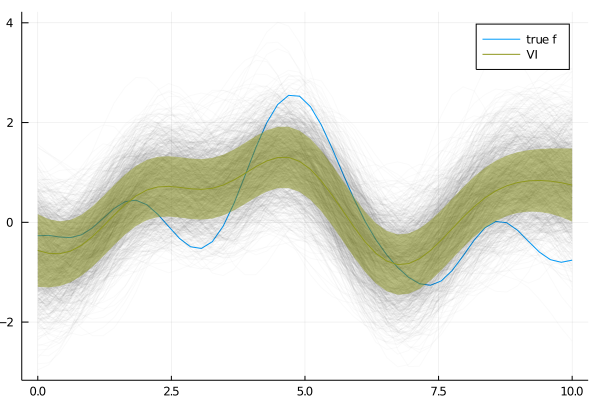

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

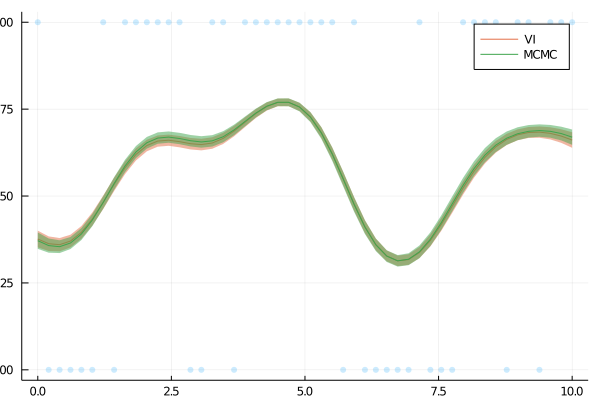

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*